# The Deep Learning Book (Simplified)
## Part II - Modern Practical Deep Networks
*This is a series of blog posts on the [Deep Learning book](http://deeplearningbook.org)
where we are attempting to provide a summary of each chapter highlighting the concepts 
that we found to be most important so that other people can use it as a starting point
for reading the chapters, while adding further explanations on few areas that we found difficult to grasp. Please refer [this](http://www.deeplearningbook.org/contents/notation.html) for more clarity on 
notation.*


## Chapter 8: Optimization for Training Deep Models

There are many types of optimization problems involved in deep learning, with the toughest one being that of training a neural network. The main theme of the chapter is to focus on one type of optimization - finding the parameters $\theta$ that reduce a cost function $J(\theta)$. <br>

The chapter is organized as follows:

**1. How Learning Differs from Pure Optimization** <br>
**2. Challenges in Neural Network Optimization** <br>
**3. Basic Algorithms** <br>
**4. Parameter Initialization Strategies** <br>
**5. Algorithms with Adaptive Learning Rates** <br>
**6. Approximate Second-Order Methods** <br>
**7. Optimization Strategies and Meta-Algorithms** 

### 1. How Learning differs from Pure Optimization

- In Machine Learning (ML), we care about a certain performance measure *P* (for e.g. accuracy) defined w.r.t the test set and optimize *$J(\theta)$* (for e.g. cross-entropy loss) with the hope that it improves *P* as well. In pure optimization, optimizing *$J(\theta)$* is the final goal.

- The expected generalization error (**risk**) is taken over the true data-generating distribution $p_{data}$. If we do have that, it becomes an optimization problem. When we don't have $p_{data}$ but a finite training set, we have a ML problem. The latter can be converted back to an optimization problem by replace $p_{data}$ with the empirical distribution, $\tilde{p}_{data}$ obtained from the training set, thereby reducing the empirical risk. This is called empirical risk minimization (ERM) and although it might look relatively similar to optimizationthere are two main problems:
    - ERM is prone to overfitting with the possibility of the dataset being learned by high capacity models.
    - ERM might not be feasible. Most optimization algorithms now are based on Gradient Descent (GD) which may not work with various loss functions like 0-1 loss (as it is not differentiable)


In [1]:
from sklearn.metrics import log_loss, zero_one_loss
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
y_true = np.ones(201, dtype='float')
y_pred = np.linspace(start=0, stop=1.0, num=201) # only the last prediction is correct

In [18]:
# storing the losses for each example
zero_one_losses = []
cross_entropy_losses = []

for i in range(len(y_true)):
    zero_one_loss_value = zero_one_loss([y_true[i]], [y_pred[i] == y_true[i]])
    cross_entropy_loss_value = log_loss([y_true[i]], [y_pred[i]], labels=[0, 1])
    zero_one_losses.append(zero_one_loss_value)
    cross_entropy_losses.append(cross_entropy_loss_value)

In [19]:
# neat visualization hack
y_max_allowed = 5
for i, loss in enumerate(cross_entropy_losses):
    if loss <= 5:
        index_to_start = i
        break

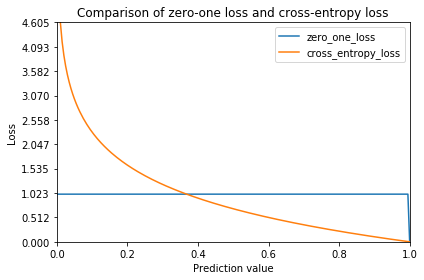

In [20]:
plt.plot(y_pred, zero_one_losses, label='zero_one_loss')
plt.plot(y_pred[index_to_start:], cross_entropy_losses[index_to_start:], label='cross_entropy_loss')
plt.legend(loc='best')
plt.xlabel('Prediction value')
plt.ylabel('Loss')
plt.title('Comparison of zero-one loss and cross-entropy loss')
plt.xticks(np.linspace(0, 1.4, 8))
plt.yticks(np.linspace(0, np.max(cross_entropy_losses[index_to_start:]), 10))
plt.tight_layout()
plt.margins(0)
plt.savefig('images/loss_comparison.png')
plt.show()

    
- It is for the reasons mentioned above that a **surrogate loss function** (SLF) is used instead that acts as a proxy. E.g. the negative log-likelihood of the true class is used as a surrogate for 0-1 loss. Using a SLF might even turn out to be beneficial as you can keep continuing to obtain a better test error by pushing the classes even further apart to get a more reliable classifier.

- Another common difference is that training might be halted following some convergence criterion based on Early Stopping to prevent overfitting, when the derivative of the surrogate loss function might still be large. This is different from pure optimization which is halted only when the derivative becomes very small. If you're not familiar with Early Stopping, I'd recommend you to look at our [previous post](https://medium.com/inveterate-learner/deep-learning-book-chapter-7-regularization-for-deep-learning-937ff261875c) where we talk about Early Stopping and other regularization techniques.

- In ML optimization algorithms that objective function decomposes as a sum over the examples and we can perform updates by randomly sampling a batch of examples and taking the average over those examples. The Standard Error of the mean estimated from *n* examples is given by $\frac {\sigma} {\sqrt{n}}$ indicating that as we include more examples for making an update, the returns of additonal examples in improving the error is less than linear. Thus, if we use 100 and 10000 example s to make an update, the latter takes 100 times more compute, but reducing the error only by a factor of 10. Thus, it's better to compute rapid approximate updates rather than a slow exact update.

- There are 3 types of sampling based algorithms - **batch gradient descent (BGD)** where the entire training set is used to make a single update, **stochastic gradient descent (SGD)** where a single example is used to make an update and **mini-batch gradient descent (MBGD)** where a batch (not to be confused with BGD) of examples is randomly sampled from the entire training set and is used to make an update. *MBGD is nowadays commonly refered to as SGD*. It is a common practise to use batch sizes as powers of 2 to offer better runtime with certain hardware. Small batches tend to have a regularizing effect because of the noise they inject as each update is made by seeing only a very small portion of the entire training set, a.k.a., a batch of samples.

- The minibatches should be selected randomly. It is sufficient to shuffle the dataset once and iterate over it multiple times. In the first epoch, the network sees each example for the first time and hence, the estimate of gradient is an *unbiased* estimate of the gradient of the true generalization error. However, from the second epoch onwards, the estimate becomes biased as it is resampling from data that it has already seen.


### 2. Challenges in Neural Network Optimization

The optimization problem for training neural networks is generally nonconvex. Some of the challenges faced are mentioned below:

- **Ill-conditioning of the Hessian Matrix**: Can cause the SGD to get stuck in a sense that even very small steps increase the cost function. Moving by a factor of $-\epsilon \mathbf{g}$  would add the term given below to the cost function. Ill-conditioning is to happen when the first term exceeds the second term. In many cases, $\mathbf{g}^TH\mathbf{g}$ does increase significantly leading to slower learning due to reduced learning rate. Thus, while the gradient norm might be increasing, it can still lead to successful training.

$$ \frac{1}{2}\epsilon^2\mathbf{g}^TH\mathbf{g} - \epsilon\mathbf{g}^T\mathbf{g} $$

- **Local minima**: Nearly any DL model is guaranteed to have an extremely large number of local minima (LM) arising due to the model identifiability problem.

![minima](images/local_minima.gif)

A model is said to be identifiable if a sufficiently large training set can rule out all but one setting of the model parameters. In case of neural networks, we can obtain equivalent models by swapping the position of the neurons. Thus, they are not identifiable.

![model_identifiability](images/model_identifiability.png)

Swapping the two hidden nodes leads to equivalent models. Thus, even after having a sufficiently large training set, there is not a unique setting of parameters. This is the model identifiability problem that neural networks suffer from.

However, all the local minima caused due to this have the same value, thus not being a problem. However, if local minima with high cost are common, it becomes a serious problem. Many points other than local minima can lead to low gradients. Nowadays, it's common to aim for a low but not minimal cost value.


- **Plateaus, Saddle Points and Other Flat Regions**: Saddle point (SP) is another type of point with zero gradient where some points around it have higher value and the others have lower. Intuitively, this means that a saddle point acts as both a local minima for some neighbors and a local maxima for the others. Thus, Hessian at SP has both +ve and -ve eigenvalues. 

![saddle](images/saddle_point.png)

For many classes of random functions, saddle points become more common at high dimensions  with the ratio of number of SPs to LMs growing exponentially with *n* for an n-dimensional space. Many random functions have an amazing property that near points with lost cost, the Hessian tends to take up mostly positive eigenvalues. SGD empirically tends to rapidly avoid encountering a high-cost saddle point. There also might be wide, flat regions of constant value, thereby having a zero gradient. These can be problematic if the cost is high in these regions.

![plateau](images/plateau.png)

- **Cliffs and Exploding Gradients**: NNs might sometimes have extremely steep regions resembling cliffs due to the repeated multiplication of weights. At the edge of such a cliff, an update step might throw the parameters extremely far. It can be taken care of by using **gradient clipping (GC)**. The gradient indicates only the direction in which to make the update. If the GD update proposes making a very large step, GC intervenes to reduce the step size.
![gradient clipping](images/gradient_clipping.png)

- **Long-Term Dependencies**: This problem is encountered when the NN becomes sufficiently deep. For example, if the same weight matrix $\mathbf{W}$ is used in each layer, after *t* steps, we'd get $\mathbf{W}^t$. Using the eigendecomposition of $\mathbf{W}$:

$$ \mathbf{W} = \mathbf{V} diag(\lambda) \mathbf{V}^T $$
$$ \mathbf{W}^t = \mathbf{V} diag(\lambda)^t \mathbf{V}^T $$

Thus, any eigenvalues not near an absolute value of 1 would either explode or vanish leading to the [**vanishing and exploding gradient problem**](https://machinelearningmastery.com/exploding-gradients-in-neural-networks/). The use of the same weight matrix is especially the case in RNNs where this is a serious problem.

![vanish explode gradient](images/exploding_vanishing_gradient.jpg)

- **Inexact Gradients**: Most optimization algorithms use a noisy/biased estimate of the gradient in cases where the estimate is based on sampling, while in cases where the true gradient is intractable for e.g. in the case of training a [Restricted Boltzmann Machine (RBM)](https://deeplearning4j.org/restrictedboltzmannmachine), an approximation of the gradient is used. For RBM, the [contrastive divergence algorithm](https://deeplearning4j.org/glossary.html#contrastivedivergence) gives a technique for approximating the gradient of its intractable log-likelihood


- Neural Networks might not end up at any critical point at all and such critical points might not even necessarily exist. A lot of the problems might be avoided if there exists a space connected to reasonably directly to the solution by a path that local descent can follow and if we are able to initialize learning within that well-behaved space. Thus, choosing good initial points should be studied.

### 3. Basic Algorithms

- **Stochastic Gradient Descent**: This has already been described before but there are certain things that should be kept in mind regarding SGD. The learning rate $\epsilon$ is a very important parameter for SGD. $\epsilon$ should be reduced after each epoch in general. This is due to the fact that the random sampling of batches acts as a source of noise which might make SGD keep oscillating around the minima without actually reaching it (the image [Source: https://goo.gl/tq6Xof] below shows this). The true gradient of the total cost function (involving the entire dataset) actually becomes 0 when we reach the minimum. Hence, BGD can use a fixed learning rate. <br>
![decrease lr](images/decrease_lr.png)
The following conditions guarantee convergence in case of SGD: 
![convergence of sgd](images/sgd_convergence.png) 
Practically, epsilon is decreased linearly until iteration $\tau$: 
![lr update](images/lr_update.png)

The main question is how to choose $\epsilon_0$. Setting it too low makes the training proceed slowly which might lead to the algorithm being stuck at a high cost value. Setting it too high would lead to large oscillations which might even push the learning outside the optimal region. The best way is to monitor the first several iterations and set the learning rate to be higher than the best performing one, but not too high to cause instability. <br> <br>

![lr_high_low](images/lr_high_low.png)

A big advantage of SGD is that the time taken to compute a weight update doesn't grow with the number of training examples as each update is computed after observing a batch of samples which is independent of the total number of training examples. Theoretically, BGD makes the error rate $O(\frac{1}{k})$ after *k* iterations whereas SGD makes it $O(\frac{1}{\sqrt{k}})$. However, SGD compensates for this with its advantages after a few iterations along with the ability to make rapid updates in the case of a large training set.

- **Momentum**: The momentum algorithm accumulates the exponentially decaying moving average of past gradients (called as velocity) and uses it as the direction in which to take the next step. Momentum is given by mass times velocity, which is equal to velocity if we're using unit mass. The momentum update is given by:

![momentum](images/momentum_update.png)

The step size (earlier equal to learning rate * gradient) now depends on how large and aligned the sequence of gradients are. If the gradients at each iteration point in the same direction (say g), it will lead to a higher value of the step size as they just keep accumulating. Once it reaches a constant (terminal) velocity, the step size becomes ϵ || g|| / (1 - α). Thus, using α as 0.9 makes the speed 10 times. Common values of α are 0.5, 0.9 and 0.99.

![momentum_visual](images/momentum.png)

Viewing it as the Newtonian dynamics of a particle sliding down a hill, the momentum algorithm consists of solving a set of differential equations via numerical simulation. There are two kinds of forces involved as shown below:

![momentum_newton](images/momentum_ball_roll.png)
Momentum can be seen as two forces operating together. 1) Proportional to the negative of the gradient such that whenever it descends a steep part of the surface, it gathers speed and continues sliding in that direction until it goes uphill again. 2) A viscous drag force (friction) proportional to -v(t) without the presence of which the particle would keep oscillating back and forth as the negative of the gradient would keep forcing it to move downhill . Viscous force is suitable as it is weak enough to allow the gradient to cause motion and strong enough to resist any motion if the gradient doesn't justify moving.

Read more about momentum in this excellent blog post by [distill.ai](http://www.distill.ai/): [Why Momentum Really Works](https://distill.pub/2017/momentum/).


- **Nesterov Momentum**: This is a slight modification of the usual momentum equation. Here, the gradient is calculated after applying the current velocity to the parameters, which can be viewed as adding a correction factor.

![nesterov](images/nesterov.png)

The intuition behind Nesterov momentum is that upon being at a point θ in the parameter space, the momentum update is going to shift the point by $\alpha$v. So, we are soon going to end up in the vicinity of ($\theta$ + $\alpha$v). Thus, it might be better to compute the gradient from that point onward. The figure below describes this visually:

![nesterov_intuition](images/nesterov.jpeg)

### 4. Parameter Initialization Strategies

Training algorithms for deep learning models are iterative in nature and require the specification of an initial point, which is extremely crucial as it decides whether the algorithm would converge or not and if it does, then is it as a point with a high cost or low cost. We have limited understanding of neural network optimization but the one property that we know with complete certainty is that the initialization should break symmetry. This means that if two hidden units are connected to the same input units, then these should have different initialization or else the gradient would update both the units in the same way and we don't learn anything new by using an additional unit. The idea of having each unit learn something different motivates random initialization of weights which is also computationally cheaper. Biases are often chosen heuristically and only the weights are randomly initialized, almost always from a Gaussian or uniform distribution. The scale of the distribution is of utmost concern. Large weights might have better symmetry-breaking effect but lead to chaos (extreme sensitivity to small perturbations in the input) and exploding values during forward & back prop. Iterative optimization algorithms like SGD tend to halt in areas near the initial values, thereby expressing a prior that the final parameters should be close to the initial values. Initializing $\mathbf{\theta}$ as $\mathbf{\theta_o}$ is similar to imposing a Gaussian prior $p(\theta)$ with mean $\theta_o$. Thus, is makes sense to choose $\theta_o$ close to 0, which says that its less likely for the units to interact.

Some heuristics include sampling from the following distributions:
- $U(-\frac{1}{\sqrt{m}}, \frac{1}{\sqrt{m}})$
- $U(-\frac{6}{\sqrt{n+m}}, \frac{6}{\sqrt{m+n}})$

One drawback to using $\frac{1}{\sqrt{m}$ as the standard deviation is that the weights end up being  small when the layers are large. **Sparse initialization** sets each unit to have exactly *k* non-zero weights, motivated from the idea to have the total amount of input to each unit independent of the number of input units, *m*. However, it takes a long time for GD to correct incorrect large values and hence, this initialization might cause problems.  

If the weights are too small, the range of activations across theminibatch will shrink as the activations propagate forward through the network.By repeatedly identifying the ﬁrst layer with unacceptably small activations andincreasing its weights, it is possible to eventually obtain a network with reasonableinitial activations throughout
 
The biases are relatively easier to choose. They are mostly set to zero excluding a few situations (refer to book for details).

### 5. Algorithms with Adaptive Learning Rates

- **AdaGrad**: It individually adapts the learning rates of all model parameters by scaling them inversely proportional to the square root of the sum of historical squared values of the gradient. However, accumulation of squared gradients from the very beginning can lead to excessive and premature decrease in the learning rate.

- **RMSProp**: It changes the gradient accumulation proposed in AdaGrad into an exponentially weighted moving average.  RMSProp uses the exponentially weighted average to discard history from the extreme past so that it can converge rapidly after finding a convex bowl, as if it were an instance of AdaGrad initialized within that bowl.

- **Adam**: Adapted from "adaptive moments", it focuses on combining RMSProp and Momentum. Firstly, it views momentum as an estimate of the first-order moment and calculates the momentum and RMSProp terms. Secondly, it adds a correction term for both the moments to account for their initialization near the origin.

### 6.  Approximate Second-Order Methods

We are using the empirical risk as the objective function.
- **Newton's Method**: Uses the second-order Taylor Series expansion to approximate the $\mathbf{\it{J}(\theta)}$ around a point $\mathbf{\theta_o}$ ignoring derivatives of higher order.<br>
![newton](images/newton.png)
We get the following critical point of the above equation:
![newton point](images/newton_point.png)
For quadratic surfaces, this directly gives the optimal result. However, for surfaces that are not quadratic, as long as the Hessian remains positive definite, we can obtain the optimal point through a 2-step iterative process - 1) Get the inverse of the Hessian and 2) update the parameters. <br><br>
Saddle points are problematic for Newton's method. If all the eigenvalues are not positive, Newton's method might cause the updates to move in the wrong direction. A way to avoid this is to add regularization:
![regularization](images/regularization.png)
However, if there is a strong negative curvature, $\alpha$ needs to be sufficiently large to offset the negative eigenvalues in which case the Hessian becomes dominated by the diagonal matrix thereby leading to an update which becomes the standard gradient divided by $\alpha$. Another problem restricting the use of Newton's method is the computational cost. It takes $O(k^3)$ time to calculate the inverse of the Hessian where $k$ is the number of parameters. And since the parameters are updated every iteration, this inverse needs to be calculated at every iteration.


- **Conjugate Gradients**: One weakness of the method of steepest descent is that line searches happen along the direction of the gradient. Suppose the previous search direction is $d_{t-1}$. Once the search terminates at the minimum, the next search direction, $d_t$ is given by the gradient at that point, which is perpendicular to $d_{t-1}$. Upon getting the minimum along the current search direction, the minimum along the previous search direction is not preserved, undoing, in a sense, the progress made in previous search direction. 
![conjugate gradient](images/conjugate_gradient.png)
In the method of conjugate gradients, we seek a search direction that is conjugate to the previous line search direction:
![conjugate_gd](images/conjugate_gd.png)
with $d_t$ and $d_{t-1}$ being called as **conjugate** if $d^T_tHd_{t-1} = 0$.
where $\beta_t$ decides how much of $d_{t-1}$ is added back to the current search direction. There are two popular choices for $\beta_t$ - Fletcher-Reeves and Polak-Ribière. These discussions assumed the cost function to be quadratic. To extend the concept to work for training neural networks, there is one additional change. Since it's no longer quadratic, there's no guarantee anymore than the conjugate direction would preserve the minimum in the previous search directions. Thus, the algorithm includes occasional resets where the method of conjugate gradients is restarted with line search along the unaltered gradient.

- **BFGS**: This algorithm tries to bring the advantages of Newton's method without the additonal computational burden by approximating $H^{-1}$ by $M_t$, which is iteratively refined using low-rank updates. Finally, line search is conducted along the direction  $M_tg_t$. BFGS requires storing the matrix $M_t$ which takes $O(n^2)$ memory making it infeasible. An approach called Limited Memory BFGS (L-BFGS) has been proposed to tackle this infeasibility by computing the matrix $M_t$ using the same method as BFGS but assuming that $M_{t-1}$ is the identity matrix.

### 7. Optimization Strategies and Meta-Learning Algorithms

- **Batch Normalization**: It is a method of adaptive reparameterization to tackle the difficulty of training deep models. 